### Setup

In [1]:
# bibliotecas
#install.packages("ROCR")
#install.packages("leaps")
#install.packages("ggplot2")
#install.packages("ggpubr")
#install.packages("caret")
library(ROCR)
require(leaps)
library(ggplot2)
library(ggpubr)
library(caret)

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: leaps
Loading required package: magrittr
Loading required package: lattice


### Aquisição dos dados

In [2]:
file_name <- "noshow_4000+_natual_trans"
#file_name <- "noshow-201808_trans"
noshowDs <- read.csv(paste(file_name, ".csv", sep = ""), sep = ";", header = TRUE, fileEncoding = "ISO-8859-1")

### Modelagem

In [3]:
# garante a repetição do experimento
set.seed(1984)

In [4]:
# criação dos conjuntos de teste (30%) e treinamento
T <- sample(1:nrow(noshowDs), round(.3 * nrow(noshowDs)))
noshowDs_test <- noshowDs[T, ]
noshowDs_train <- noshowDs[-T, ]

In [5]:
# ajsuta um modelo de regressão logística sobre todos os parâmetros do conjunto de treinamento
# usa a função step para comparar diferentes arranjos entre as variáeveis preditoras
completo <- IsNoShow ~ .
fit <- glm(completo, data=noshowDs_train, family = binomial, control = list(maxit = 25))
fit <- step(fit, data = noshowDs_train)

Start:  AIC=1788.74
IsNoShow ~ Idade + GeneroPaciente + IsPacienteUnicoAtendimento + 
    IsNovoPaciente + LeadTime + Mes + DiaSemana + Hora + IsPacientePossuiFone + 
    QtdRedesSociais + IsPacientePossuiEmail + IsParticular + 
    GeneroExecutante + QtdNoShowPaciente + QtdAgendamentosPaciente + 
    RazaoNoShowPaciente

                             Df Deviance    AIC
- GeneroPaciente              2   1750.9 1784.9
- IsNovoPaciente              1   1750.7 1786.7
- Idade                       1   1750.8 1786.8
- IsPacientePossuiEmail       1   1750.8 1786.8
- IsPacientePossuiFone        1   1750.9 1786.9
- QtdRedesSociais             1   1751.0 1787.0
- Mes                         1   1751.4 1787.4
- IsPacienteUnicoAtendimento  1   1751.4 1787.4
- QtdAgendamentosPaciente     1   1752.0 1788.0
- Hora                        1   1752.1 1788.1
<none>                            1750.7 1788.7
- LeadTime                    1   1752.8 1788.8
- QtdNoShowPaciente           1   1753.8 1789.8
- Ge

In [6]:
summary(fit)


Call:
glm(formula = IsNoShow ~ LeadTime + DiaSemana + IsParticular + 
    GeneroExecutante + QtdNoShowPaciente + QtdAgendamentosPaciente + 
    RazaoNoShowPaciente, family = binomial, data = noshowDs_train, 
    control = list(maxit = 25))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3127  -0.4123  -0.3333  -0.2876   2.5782  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -3.11447    0.27025 -11.525  < 2e-16 ***
LeadTime                 0.06076    0.03502   1.735  0.08271 .  
DiaSemana                0.09460    0.04034   2.345  0.01901 *  
IsParticularTRUE         0.72137    0.26110   2.763  0.00573 ** 
GeneroExecutanteM       -0.30984    0.13663  -2.268  0.02334 *  
GeneroExecutanteN        0.51166    1.30197   0.393  0.69433    
QtdNoShowPaciente        0.11869    0.07015   1.692  0.09064 .  
QtdAgendamentosPaciente -0.02439    0.01872  -1.303  0.19266    
RazaoNoShowPaciente      6.26727    0.38488  

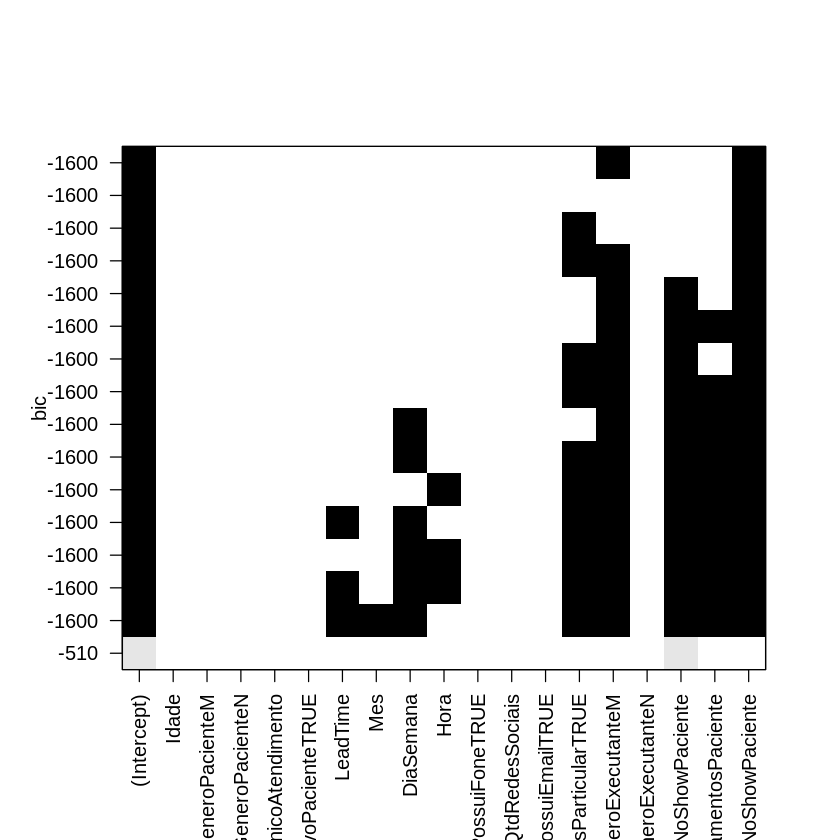

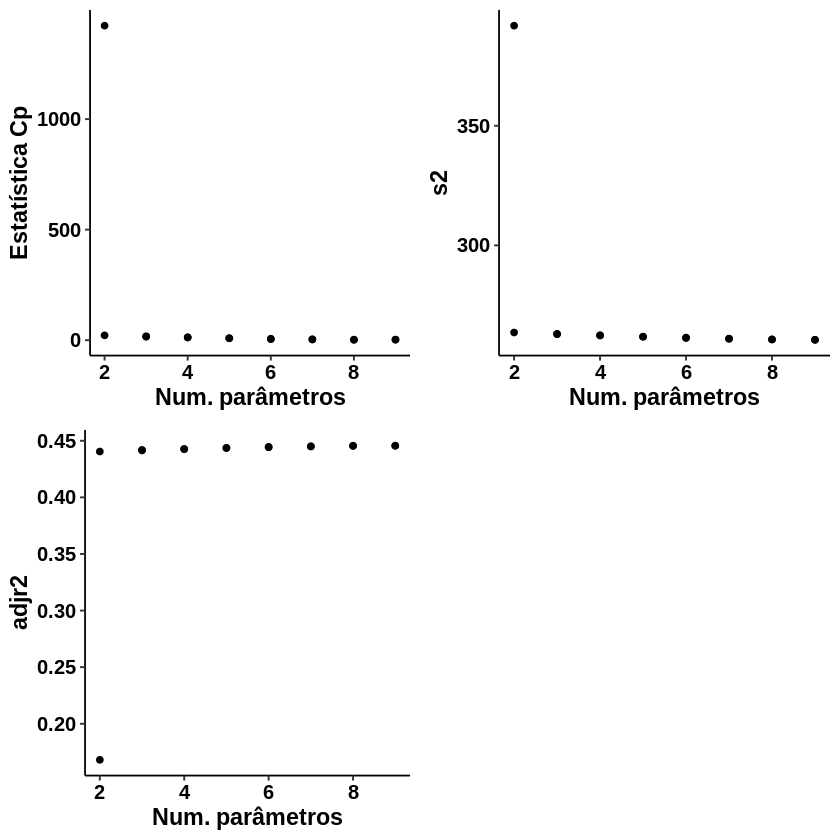

In [7]:
subsets <- regsubsets(completo, nbest = 2, data = noshowDs_train)
plot(subsets)

subsets_summary <- summary(subsets)
subsets_summary_df <- data.frame(
    np = as.numeric(rownames(subsets_summary$which)) + 1,
    cp = subsets_summary$cp,
    adjr2 = subsets_summary$adjr2,
    s2 = subsets_summary$rss
)
g1 <- ggplot(data = subsets_summary_df, aes(x = np, y = cp)) + geom_point() + ylab("Estatística Cp") + xlab("Num. parâmetros") + theme_pubr() + labs_pubr()
g2 <- ggplot(data = subsets_summary_df, aes(x = np, y = s2)) + geom_point() + ylab("s2") + xlab("Num. parâmetros") + theme_pubr() + labs_pubr()
g3 <- ggplot(data = subsets_summary_df, aes(x = np, y = adjr2)) + geom_point() + ylab("adjr2") + xlab("Num. parâmetros") + theme_pubr() + labs_pubr()
ggarrange(g1, g2, g3, ncol = 2, nrow = 2)

In [8]:
#fit <- glm(IsNoShow ~ IsNovoPaciente + LeadTime + Mes + QtdAgendamentosPaciente + RazaoNoShowPaciente, data=noshowDs_train, family = binomial)

In [9]:
# aplica o modelo para predição no conjunto de teste
#fit$xlevels[["EnderecoBairroPaciente"]] <- union(fit$xlevels[["EnderecoBairroPaciente"]], levels(noshowDs_test$EnderecoBairroPaciente))
predict_test <- predict(fit, newdata = noshowDs_test, type = "response") > .5

In [10]:
# Matriz de confusão do modelo e acurácia do modelo
caret::confusionMatrix(
    factor(predict_test, levels = c("TRUE", "FALSE")), 
    factor(noshowDs_test$IsNoShow, levels = c("TRUE", "FALSE")), 
    positive = "TRUE"
)

Confusion Matrix and Statistics

          Reference
Prediction TRUE FALSE
     TRUE   145    37
     FALSE  130   914
                                          
               Accuracy : 0.8638          
                 95% CI : (0.8433, 0.8825)
    No Information Rate : 0.7757          
    P-Value [Acc > NIR] : 3.648e-15       
                                          
                  Kappa : 0.5551          
                                          
 Mcnemar's Test P-Value : 1.086e-12       
                                          
            Sensitivity : 0.5273          
            Specificity : 0.9611          
         Pos Pred Value : 0.7967          
         Neg Pred Value : 0.8755          
             Prevalence : 0.2243          
         Detection Rate : 0.1183          
   Detection Prevalence : 0.1485          
      Balanced Accuracy : 0.7442          
                                          
       'Positive' Class : TRUE            
                     

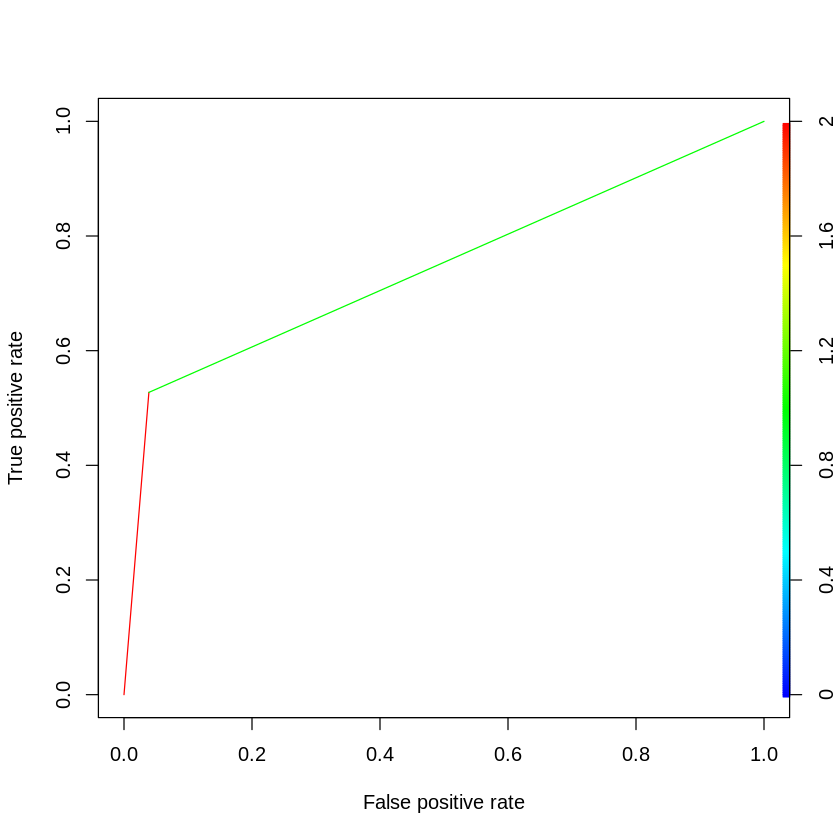

In [11]:
# curva ROC
pr <- prediction(as.numeric(predict_test), as.numeric(noshowDs_test$IsNoShow))
prf <- performance(pr, measure = "tpr", x.measure = "fpr")
plot(prf, colorize = TRUE)

In [12]:
# Area under ROC curve 
auc=performance(pr, measure="auc")
auc=auc@y.values[[1]]
auc

[1] 0.7441832

### Exploração do modelo

In [13]:
# visualização do modelo
summary(fit)


Call:
glm(formula = IsNoShow ~ LeadTime + DiaSemana + IsParticular + 
    GeneroExecutante + QtdNoShowPaciente + QtdAgendamentosPaciente + 
    RazaoNoShowPaciente, family = binomial, data = noshowDs_train, 
    control = list(maxit = 25))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3127  -0.4123  -0.3333  -0.2876   2.5782  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -3.11447    0.27025 -11.525  < 2e-16 ***
LeadTime                 0.06076    0.03502   1.735  0.08271 .  
DiaSemana                0.09460    0.04034   2.345  0.01901 *  
IsParticularTRUE         0.72137    0.26110   2.763  0.00573 ** 
GeneroExecutanteM       -0.30984    0.13663  -2.268  0.02334 *  
GeneroExecutanteN        0.51166    1.30197   0.393  0.69433    
QtdNoShowPaciente        0.11869    0.07015   1.692  0.09064 .  
QtdAgendamentosPaciente -0.02439    0.01872  -1.303  0.19266    
RazaoNoShowPaciente      6.26727    0.38488  

In [14]:
# transformação sobre os parâmetros do modelo
exp(coef(fit))

(Intercept)                LeadTime               DiaSemana 
             0.04440196              1.06264173              1.09921841 
       IsParticularTRUE       GeneroExecutanteM       GeneroExecutanteN 
             2.05724903              0.73356341              1.66805909 
      QtdNoShowPaciente QtdAgendamentosPaciente     RazaoNoShowPaciente 
             1.12602465              0.97590479            527.03799070

In [15]:
varImp(fit, scale = FALSE)

,Overall
,<dbl>
LeadTime,1.7351981
DiaSemana,2.3452881
IsParticularTRUE,2.7627601
GeneroExecutanteM,2.2677556
GeneroExecutanteN,0.3929895
QtdNoShowPaciente,1.6920334
QtdAgendamentosPaciente,1.3027415
RazaoNoShowPaciente,16.2837690


In [16]:
# salva o modelo
save(file = 'logit-step.model', fit)

### Teste em um novo conjunto de dados

In [17]:
nome_arquivo <- "noshow_201808"
noshowDs <- read.csv(paste(nome_arquivo, ".csv", sep = ""), sep = ";", header = TRUE, fileEncoding = "ISO-8859-1")

In [18]:
# dimensões do dataset
dim(noshowDs)

[1] 592  45

In [19]:
# seleciona 100 elementos para o teste
T <- sample(1:nrow(noshowDs), 100)
noshowDs <- noshowDs[T, ]

In [20]:
head(noshowDs)
tail(noshowDs)
summary(noshowDs)

,IsNoShow,DataNascimento,Idade,GeneroPaciente,IsPacienteUnicoAtendimento,IsNovoPaciente,Profissao,LeadTime,Mes,DiaSemana,⋯,GeneroExecutante,IsProcedimentoComJejum,IsProcedimentoComPreparacao,IsTodosExamesMesmaUnidade,IsAgendamentoComNecessidadesEspeciais,Perguntas,PerguntasDescricao,Respostas,QtdNoShowPaciente,QtdAgendamentosPaciente
,<int>,<fct>,<int>,<fct>,<int>,<int>,<fct>,<int>,<int>,<int>,⋯,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>
64,1,1954-07-05,66,M,1,1,null,1,8,6,⋯,M,0,1,0,0,null,null,null,1,1
498,0,1933-02-16,87,F,0,0,null,3,8,7,⋯,F,0,1,0,0,null,null,null,0,7
369,0,1943-02-15,77,F,0,0,MEDICO ORTOMOLECULAR,5,8,7,⋯,M,0,1,0,0,null,null,null,0,9
218,1,1932-10-30,88,M,0,0,MEDICO ORTOMOLECULAR,2,8,7,⋯,M,0,1,0,0,null,null,null,1,4
107,0,1930-03-15,90,F,0,0,MEDICO ORTOMOLECULAR,1,8,3,⋯,M,0,1,0,0,null,null,null,1,3
417,1,2011-12-16,9,M,1,1,null,7,8,4,⋯,F,0,1,0,0,null,null,null,1,1


,IsNoShow,DataNascimento,Idade,GeneroPaciente,IsPacienteUnicoAtendimento,IsNovoPaciente,Profissao,LeadTime,Mes,DiaSemana,⋯,GeneroExecutante,IsProcedimentoComJejum,IsProcedimentoComPreparacao,IsTodosExamesMesmaUnidade,IsAgendamentoComNecessidadesEspeciais,Perguntas,PerguntasDescricao,Respostas,QtdNoShowPaciente,QtdAgendamentosPaciente
,<int>,<fct>,<int>,<fct>,<int>,<int>,<fct>,<int>,<int>,<int>,⋯,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>
331,0,2009-05-09,11,M,0,0,MEDICO ORTOMOLECULAR,3,8,5,⋯,M,0,1,0,0,null,null,null,2,3
289,0,1934-01-10,86,F,0,0,MEDICO ORTOMOLECULAR,2,8,4,⋯,M,0,1,0,0,null,null,null,0,2
563,0,1936-02-21,84,F,0,0,null,3,8,5,⋯,M,0,1,0,0,null,null,null,1,6
551,1,1933-03-28,87,M,0,0,MEDICO ORTOMOLECULAR,2,8,4,⋯,M,0,1,0,0,null,null,null,1,19
25,0,1951-05-02,69,F,0,0,MEDICO ORTOMOLECULAR,3,8,5,⋯,F,0,1,0,0,null,null,null,0,2
529,0,1945-12-29,75,F,0,0,null,1,8,3,⋯,F,0,1,0,0,null,null,null,1,10


    IsNoShow       DataNascimento     Idade       GeneroPaciente
 Min.   :0.00   1933-03-28: 3     Min.   : 4.00   F:68          
 1st Qu.:0.00   1926-12-07: 2     1st Qu.:63.75   M:32          
 Median :0.00   1931-04-20: 2     Median :80.00                 
 Mean   :0.15   1932-10-30: 2     Mean   :72.44                 
 3rd Qu.:0.00   1971-09-07: 2     3rd Qu.:87.25                 
 Max.   :1.00   1922-02-17: 1     Max.   :98.00                 
                (Other)   :88                                   
 IsPacienteUnicoAtendimento IsNovoPaciente                Profissao 
 Min.   :0.00               Min.   :0.00   Médico              : 0  
 1st Qu.:0.00               1st Qu.:0.00   MEDICO ORTOMOLECULAR:63  
 Median :0.00               Median :0.00   null                :37  
 Mean   :0.27               Mean   :0.29                            
 3rd Qu.:1.00               3rd Qu.:1.00                            
 Max.   :1.00               Max.   :1.00                          

In [21]:
# remoção de colunas que não serão utilizadas na modelagem
col_excluir <- c(
    "DataNascimento",
    "EnderecoCidadeUnidade", "EnderecoBairroUnidade", "EnderecoCepUnidade",
    "EnderecoCidadePaciente", "EnderecoBairroPaciente", "EnderecoCepPaciente",
    "Profissao", "IsEmancipado", "EspecialidadeSolicitante", "ProcedimentoMnemonico", 
    "Procedimento", "ProcedimentoDescricao", "Setor", "SetorDescricao",
    "IsVip", "Perguntas", "PerguntasDescricao", "Respostas", "Segmento", "IsFeriado",
    # não estavam deixando o modelo convergir...
    "EstacaoAno","IsEncaixe","IsIndicacaoMedica","IsProcedimentoComJejum", "IsProcedimentoComPreparacao",
    "IsTodosExamesMesmaUnidade", "IsAgendamentoComNecessidadesEspeciais", "IsAgendamentoPossuiExecutante"
)
noshowDs <- noshowDs[!(names(noshowDs) %in% col_excluir)]

In [22]:
# transforma todas as string "null" em NA
noshowDs[noshowDs == "null"] <- NA
#noshowDs[noshowDs$GeneroExecutante == "N",] <- NA
noshowDs <- na.omit(noshowDs)

In [23]:
# transformação da coluna de horário em numérico
# calcula a quantidade de segundos a partir de 00:00:00
tmp1 <- paste(Sys.Date(), " ", noshowDs$Hora)
tmp2 <- as.POSIXct(tmp1)
tmp3 <- as.POSIXct(paste(Sys.Date(), " 00:00:00"))
noshowDs$Hora <- as.numeric(tmp2) - as.numeric(tmp3)

In [24]:
# transforma todas as colunas 0/1 em FALSE/TRUE
bool_columns <- c(
    "IsNoShow", "IsNovoPaciente", "IsPacientePossuiFone", "IsPacientePossuiEmail", "IsParticular"
)
noshowDs[bool_columns] <- noshowDs[bool_columns] == 1

In [25]:
#noshowDs <- noshowDs[c("IsNoShow", "QtdNoShowPaciente", "QtdAgendamentosPaciente", "IsNovoPaciente")]

In [26]:
# cria uma coluna com a razão de no-show do paciente
noshowDs["RazaoNoShowPaciente"] <- noshowDs["QtdNoShowPaciente"] / noshowDs["QtdAgendamentosPaciente"]

In [27]:
# aplica o modelo para predição no conjunto de teste
predict_test <- predict(fit, newdata = noshowDs, type = "response") > .5

In [28]:
# Matriz de confusão do modelo e acurácia do modelo
caret::confusionMatrix(
    factor(noshowDs$IsNoShow, levels = c("TRUE", "FALSE")), 
    factor(predict_test, levels = c("TRUE", "FALSE")), 
    positive = "TRUE"
)

Confusion Matrix and Statistics

          Reference
Prediction TRUE FALSE
     TRUE     5    10
     FALSE    7    78
                                          
               Accuracy : 0.83            
                 95% CI : (0.7418, 0.8977)
    No Information Rate : 0.88            
    P-Value [Acc > NIR] : 0.9489          
                                          
                  Kappa : 0.2735          
                                          
 Mcnemar's Test P-Value : 0.6276          
                                          
            Sensitivity : 0.4167          
            Specificity : 0.8864          
         Pos Pred Value : 0.3333          
         Neg Pred Value : 0.9176          
             Prevalence : 0.1200          
         Detection Rate : 0.0500          
   Detection Prevalence : 0.1500          
      Balanced Accuracy : 0.6515          
                                          
       'Positive' Class : TRUE            
                     

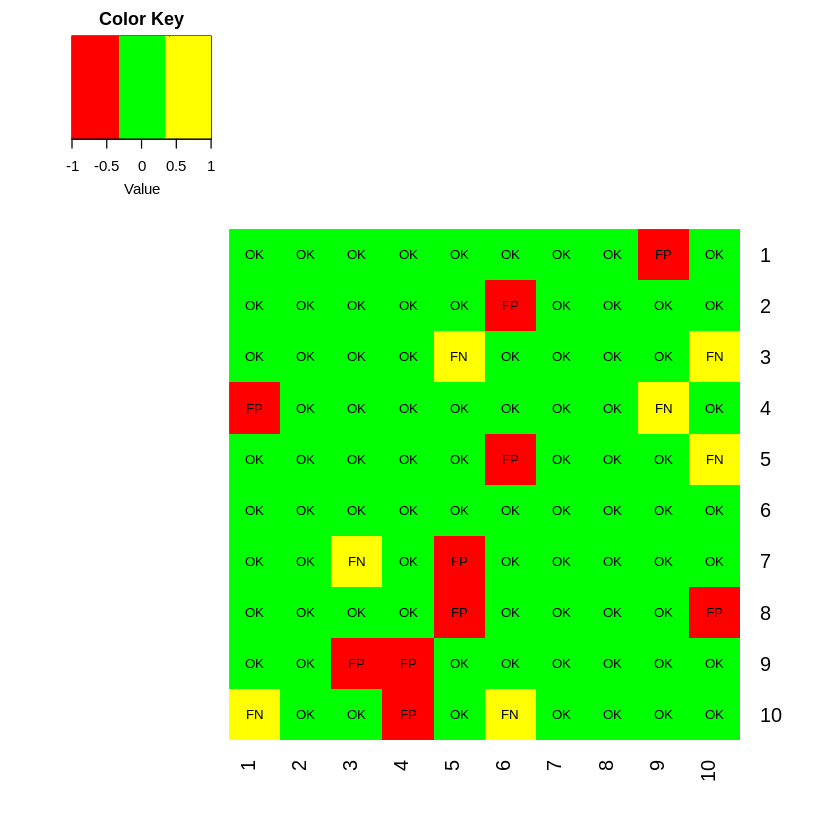

In [29]:
x <- matrix(as.numeric(predict_test - noshowDs$IsNoShow), nrow = 10, ncol = 10)
xval <- x
xval[xval == 0] <- "OK"
xval[xval == -1] <- "FP"
xval[xval == 1] <- "FN"
pal <- c("red", "green", "yellow") #colorRampPalette(c(rgb(0.96,0.96,1), rgb(0.1,0.1,0.9)), space = "rgb")
heatmap.2(
    x,
    Rowv=FALSE, Colv=FALSE, dendrogram="none", 
    col=pal, tracecol="#303030", trace="none", cellnote=xval, 
    density.info = "none", 
    notecol="black", notecex=0.8, keysize = 1.5, margins=c(5, 5)
)

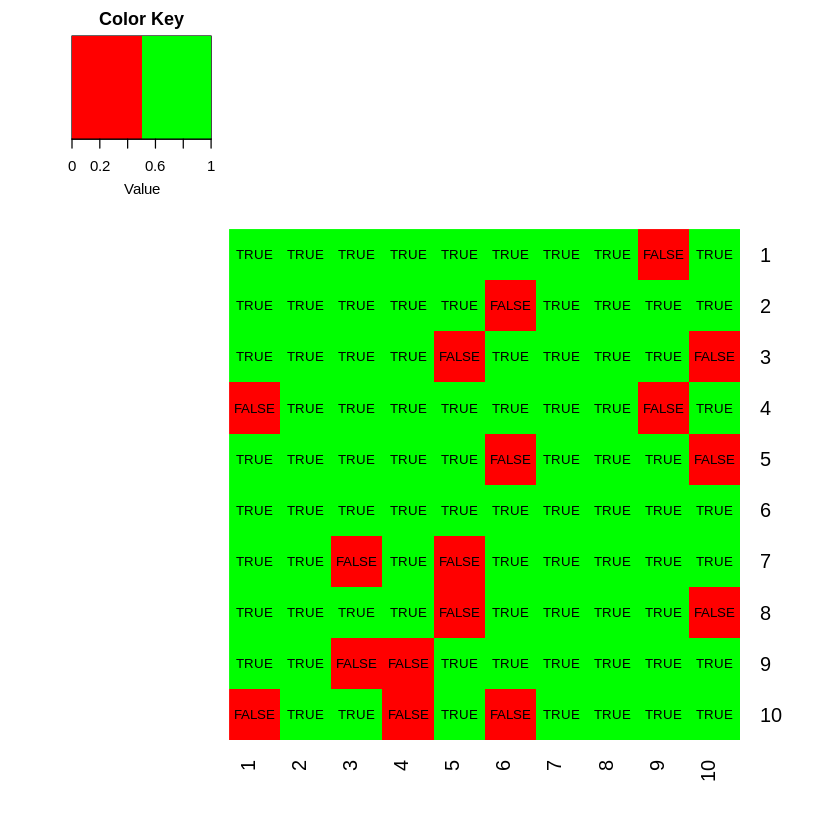

In [30]:
x <- matrix(as.numeric(predict_test == noshowDs$IsNoShow), nrow = 10, ncol = 10)
xval <- x == 1 #formatC(x, format="f", digits=2)
pal <- c("red","green") #colorRampPalette(c(rgb(0.96,0.96,1), rgb(0.1,0.1,0.9)), space = "rgb")
heatmap.2(
    x,
    Rowv=FALSE, Colv=FALSE, dendrogram="none", 
    col=pal, tracecol="#303030", trace="none", cellnote=xval, 
    density.info = "none", 
    notecol="black", notecex=0.8, keysize = 1.5, margins=c(5, 5)
)